This notebook will go through the pipeline for normalizing an fMRI dataset into the MNI template space.

Importing modules

In [29]:
%matplotlib inline
import os, shutil
import sklearn.metrics
import nibabel
import numpy
import nilearn.plotting
import matplotlib.pyplot as plt
from nipype.interfaces import fsl, ants
from nipype.caching import Memory

mem = Memory(base_dir=os.getcwd())

try:
    datadir=os.environ['FMRIDATADIR']
    assert not datadir==''
except:
    datadir='/Users/poldrack/data_unsynced/myconnectome/sub00001'
print 'Using data from',datadir

results_dir = os.path.abspath("../results")
if not os.path.exists(results_dir):
    os.mkdir(results_dir)

Using data from /home/vagrant/data


Setting up variables

In [30]:
subject='ses014'  
# note - we have to use the anatomy from a different session'
anat_subject='ses018'
bolddir=os.path.join(datadir,'ds031/sub00001',subject,
        'functional')

meanbold_unwarped_file=os.path.join(results_dir, "meanbold_unwarped.nii.gz")
meanbold=os.path.join(results_dir, "meanbold.nii.gz")
fmapmag=os.path.join(results_dir, "fmapmag.nii.gz")
fmapmagbrain=os.path.join(results_dir, "fmapmagbrain.nii.gz")
fmap=os.path.join(results_dir, "fieldmap.nii.gz")
bold_file=os.path.join(bolddir,
    'sub00001_ses014_task002_run001_bold_mcf_brain_unwarped.nii.gz')
anatomydir=os.path.join(datadir,'ds031/sub00001',anat_subject,
        'anatomy')
t1file=os.path.join(anatomydir,'sub00001_ses018_T1w_001.nii.gz')

## Bias field correction of the T1

In [31]:
bias_field_correcton = mem.cache(ants.N4BiasFieldCorrection)
bias_field_correcton_results = bias_field_correcton(input_image = t1file, 
                                                    dimension = 3,
                                                    save_bias = True)
bias_field_correcton_results.outputs

INFO:workflow:Executing node 806a4ed0b080946a11dfa6ece7d7bcce in dir: /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-ants-segmentation-N4BiasFieldCorrection/806a4ed0b080946a11dfa6ece7d7bcce
INFO:workflow:Collecting precomputed outputs



bias_image = /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-ants-segmentation-N4BiasFieldCorrection/806a4ed0b080946a11dfa6ece7d7bcce/sub00001_ses018_T1w_001_bias.nii.gz
output_image = /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-ants-segmentation-N4BiasFieldCorrection/806a4ed0b080946a11dfa6ece7d7bcce/sub00001_ses018_T1w_001_corrected.nii.gz

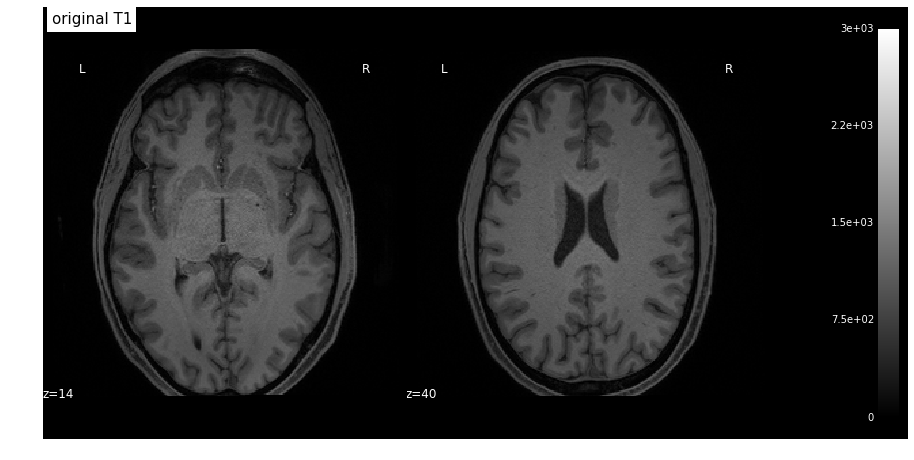

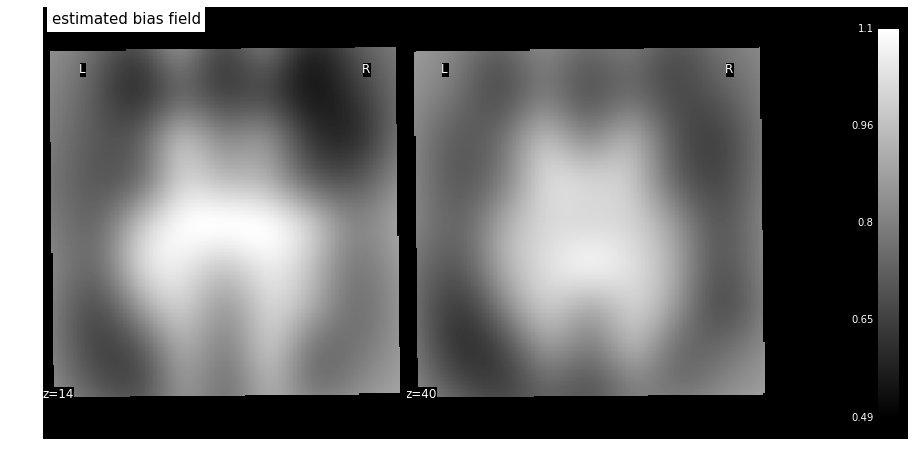

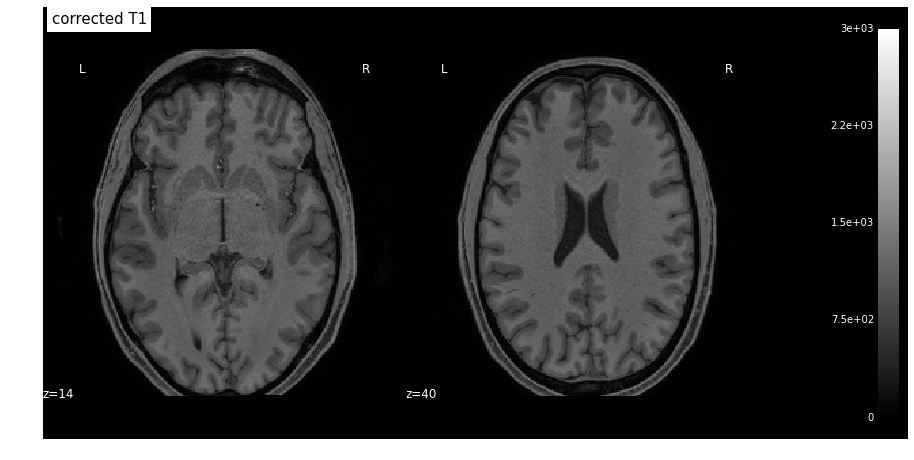

In [32]:
fig = plt.figure(figsize=(12,6))
nilearn.plotting.plot_anat(t1file, colorbar=True, vmax=3000, display_mode='z', cut_coords=(14, 40), 
                           title="original T1", figure=fig)
fig = plt.figure(figsize=(12,6))
nilearn.plotting.plot_anat(bias_field_correcton_results.outputs.bias_image, display_mode='z', 
                          cut_coords=(14, 40), colorbar=True, title="estimated bias field", figure=fig)
fig = plt.figure(figsize=(12,6))
nilearn.plotting.plot_anat(bias_field_correcton_results.outputs.output_image, colorbar=True, 
                           vmax=3000, display_mode='z', cut_coords=(14, 40), title="corrected T1", figure=fig)

## Brain extraction using BET

In [33]:
bet = mem.cache(fsl.BET)
bet_results = bet(in_file=bias_field_correcton_results.outputs.output_image,
                  mask=True,
                  frac=0.3)
bet_results.outputs

INFO:workflow:Executing node c8f784997e8bc71921a1e6a92043791c in dir: /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-preprocess-BET/c8f784997e8bc71921a1e6a92043791c
INFO:workflow:Collecting precomputed outputs



inskull_mask_file = <undefined>
inskull_mesh_file = <undefined>
mask_file = /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-preprocess-BET/c8f784997e8bc71921a1e6a92043791c/sub00001_ses018_T1w_001_corrected_brain_mask.nii.gz
meshfile = <undefined>
out_file = /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-preprocess-BET/c8f784997e8bc71921a1e6a92043791c/sub00001_ses018_T1w_001_corrected_brain.nii.gz
outline_file = <undefined>
outskin_mask_file = <undefined>
outskin_mesh_file = <undefined>
outskull_mask_file = <undefined>
outskull_mesh_file = <undefined>
skull_mask_file = <undefined>

Visualize brain mask overlaid on anatomy

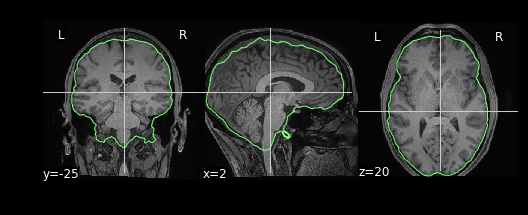

In [34]:
mask_display=nilearn.plotting.plot_epi(t1file,cmap='gray')
mask_display.add_contours(bet_results.outputs.mask_file, levels=[.5]) 

## Combined corregistration and fieldmap unwarping using boundary based registration

Please note that we are using mean EPI image instead of whole time series.

In [35]:
epi_reg = mem.cache(fsl.EpiReg)
epi_reg_results = epi_reg(epi=meanbold,
                          t1_head=bias_field_correcton_results.outputs.output_image,
                          t1_brain=bet_results.outputs.out_file,
                          fmap=fmap,
                          fmapmag=fmapmag,
                          fmapmagbrain=fmapmagbrain,
                          echospacing=2.6/10000.0,
                          pedir='y',
                          out_base="epi2struct")
epi_reg_results.outputs

INFO:workflow:Executing node 2bf7c4c475822f80a6e12984eb73b3d6 in dir: /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-epi-EpiReg/2bf7c4c475822f80a6e12984eb73b3d6
INFO:workflow:Collecting precomputed outputs



epi2str_inv = /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-epi-EpiReg/2bf7c4c475822f80a6e12984eb73b3d6/epi2struct_inv.mat
epi2str_mat = /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-epi-EpiReg/2bf7c4c475822f80a6e12984eb73b3d6/epi2struct.mat
fmap2epi_mat = /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-epi-EpiReg/2bf7c4c475822f80a6e12984eb73b3d6/epi2struct_fieldmaprads2epi.mat
fmap2str_mat = /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-epi-EpiReg/2bf7c4c475822f80a6e12984eb73b3d6/epi2struct_fieldmap2str.mat
fmap_epi = /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-epi-EpiReg/2bf7c4c475822f80a6e12984eb73b3d6/epi2struct_fieldmaprads2epi.nii.gz
fmap_str = /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-epi-EpiReg/2bf7c4c475822f80a6e12984eb73b3d6/epi2

Boundary based registration used grey/white matter interface to corregister EPI and T1 images. This boundary has been estimated from the T1 image.

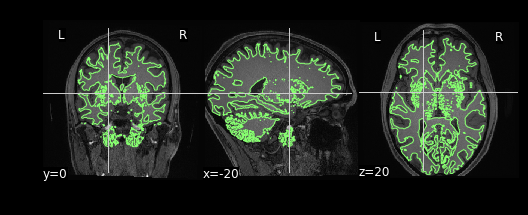

In [36]:
mask_display=nilearn.plotting.plot_epi(t1file,cmap='gray', cut_coords=(-20,0,20))
mask_display.add_contours(epi_reg_results.outputs.wmseg, levels=[.5]) 

To evaluate the quality of the corregistration lets overlay the grey-white matter border on top of the EPI image.

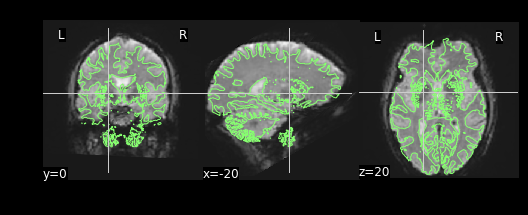

In [37]:
mask_display=nilearn.plotting.plot_epi(epi_reg_results.outputs.out_file,cmap='gray', cut_coords=(-20,0,20))
mask_display.add_contours(epi_reg_results.outputs.wmseg, levels=[.5]) 

## Normalization (T1 to MNI corregistration) using ANTs

To save time we will reduce the number of iterations.

In [38]:
ants_reg = mem.cache(ants.Registration)
ants_results = ants_reg(fixed_image = os.path.join(os.getenv('FSLDIR'),'data/standard/MNI152_T1_2mm_brain.nii.gz'),
                    moving_image = bias_field_correcton_results.outputs.output_image,
                    transforms = ['Translation', 'Rigid', 'Affine', 'SyN'],
                    transform_parameters = [(0.1,), (0.1,), (0.1,), (0.2, 3.0, 0.0)],
                    #number_of_iterations = ([[10000, 111110, 11110]]*3 +
                    #                [[100, 50, 30]]),
                    number_of_iterations = ([[10, 10, 10]]*3 +
                                    [[1, 5, 3]]),
                    dimension = 3,
                    write_composite_transform = True,
                    metric = ['Mattes'] * 3 + [['Mattes', 'CC']],
                    metric_weight = [1] * 3 + [[0.5, 0.5]],
                    radius_or_number_of_bins = [32] * 3 + [[32, 4]],
                    sampling_strategy = ['Regular'] * 3 + [[None, None]],
                    sampling_percentage = [0.3] * 3 + [[None, None]],
                    convergence_threshold = [1.e-8] * 3 + [-0.01],
                    convergence_window_size = [20] * 3 + [5],
                    smoothing_sigmas = [[4, 2, 1]] * 3 + [[1, 0.5, 0]],
                    sigma_units = ['vox'] * 4,
                    shrink_factors = [[6, 4, 2]] + [[3, 2, 1]]*2 + [[4, 2, 1]],
                    use_estimate_learning_rate_once = [True] * 4,
                    use_histogram_matching = [False] * 3 + [True],
                    initial_moving_transform_com = True,
                    output_warped_image = True)
ants_results.outputs

/home/vagrant/miniconda/lib/python2.7/site-packages/nipype/interfaces/base.py:412: UserWarning: Input sigma_units requires inputs: smoothing_sigmas
  warn(msg)
/home/vagrant/miniconda/lib/python2.7/site-packages/nipype/interfaces/base.py:412: UserWarning: Input sampling_percentage requires inputs: sampling_strategy
  warn(msg)
/home/vagrant/miniconda/lib/python2.7/site-packages/nipype/interfaces/base.py:412: UserWarning: Input convergence_threshold requires inputs: number_of_iterations
  warn(msg)
/home/vagrant/miniconda/lib/python2.7/site-packages/nipype/interfaces/base.py:412: UserWarning: Input metric_weight requires inputs: metric
  warn(msg)
INFO:workflow:Executing node 2f839e42b7d525ad86eff029c7cf641d in dir: /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-ants-registration-Registration/2f839e42b7d525ad86eff029c7cf641d
INFO:workflow:Collecting precomputed outputs



composite_transform = ['/home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-ants-registration-Registration/2f839e42b7d525ad86eff029c7cf641d/transformComposite.h5']
forward_invert_flags = []
forward_transforms = []
inverse_composite_transform = ['/home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-ants-registration-Registration/2f839e42b7d525ad86eff029c7cf641d/transformInverseComposite.h5']
inverse_warped_image = <undefined>
reverse_invert_flags = []
reverse_transforms = []
save_state = <undefined>
warped_image = /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-ants-registration-Registration/2f839e42b7d525ad86eff029c7cf641d/transform_Warped.nii.gz

Lets plot the normalized subject brain next to the MNI template.

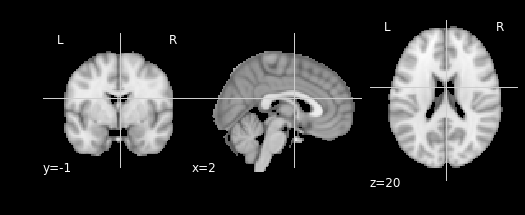

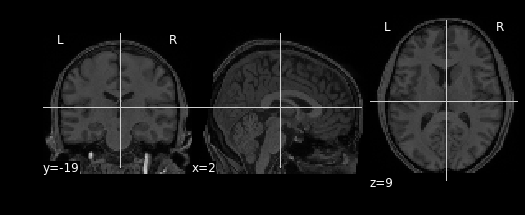

In [39]:
nilearn.plotting.plot_anat(os.path.join(os.getenv('FSLDIR'),'data/standard/MNI152_T1_2mm_brain.nii.gz'))
nilearn.plotting.plot_anat(ants_results.outputs.warped_image)

Again we can plot grey-white matter outline as an overlay to asses the quality of the corregistration. First we need to warp the WM segmentation file to the MNI space using just estimated transform

In [40]:
T1_to_MNI_warp = mem.cache(ants.ApplyTransforms)
T1wm_to_MNI_warp_results = T1_to_MNI_warp(input_image = epi_reg_results.outputs.wmseg,
                                          reference_image = os.path.join(os.getenv('FSLDIR'),'data/standard/MNI152_T1_2mm_brain.nii.gz'),
                                          interpolation = "NearestNeighbor",
                                          transforms = ants_results.outputs.composite_transform)
T1wm_to_MNI_warp_results.outputs

INFO:workflow:Executing node 2ba204050dca7c323c5c76914845eb06 in dir: /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-ants-resampling-ApplyTransforms/2ba204050dca7c323c5c76914845eb06
INFO:workflow:Collecting precomputed outputs



output_image = /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-ants-resampling-ApplyTransforms/2ba204050dca7c323c5c76914845eb06/epi2struct_fast_wmseg_trans.nii.gz

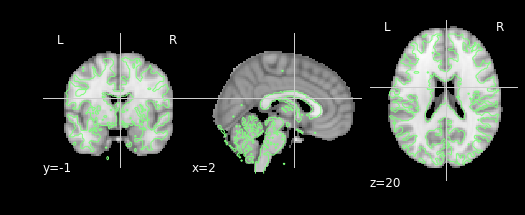

In [41]:
fig = nilearn.plotting.plot_anat(os.path.join(os.getenv('FSLDIR'),'data/standard/MNI152_T1_2mm_brain.nii.gz'))
fig.add_contours(T1wm_to_MNI_warp_results.outputs.output_image, levels=[.5]) 

Note that we have not yet combined the two transformations. We will do that when it comes to group level analysis. We will apply the combined transformations to single subject (first level) contrast maps.